In [14]:
import cv2
import matplotlib.patches as patches
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
import shapely

from anpr.binarization.adaptative_gaussian import AdaptativeGaussianBinarizer
from anpr.binarization.adaptative_mean import AdaptativeMeanBinarizer
from anpr.binarization.kittler import KittlerBinarizer
from anpr.binarization.otsu import OtsuBinarizer
from anpr.core.binarizer import Binarizer
from anpr.core.image_processor import ImageProcessor
from anpr.datasets.open_alpr import OpenALPRDataset, OpenALPRImage
from anpr.generic.brightness import Brightness
from anpr.generic.contrast import Contrast
from anpr.generic.filter_bilateral import FilterBilateral
from anpr.generic.filter_gaussian import FilterGaussian
from anpr.generic.filter_mean import FilterMean
from anpr.generic.filter_median import FilterMedian
from anpr.generic.filter_nlm import FilterNLM
from anpr.generic.grayscale import GrayScale
from anpr.generic.histogram_normalization import HistogramNormalization
from anpr.generic.morphological_closing import MorphologicalClosing
from anpr.generic.morphological_opening import MorphologicalOpening
from anpr.generic.negative import Negative
from anpr.ocr.easy_ocr import EasyOCR

In [15]:
ds = OpenALPRDataset()
img = ds.image_at(20)
gray = GrayScale().process(img.image)

In [16]:
def apply(image: OpenALPRImage,
          preprocessing: list[ImageProcessor],
          cmap=None):
    img = only_apply(image.image,
                     preprocessing)
    show(img,
         image.plate_rect,
         cmap=cmap)


def only_apply(img: np.ndarray,
               preprocessing: list[ImageProcessor]):
    # Aplicando operações
    for p in preprocessing:
        img = p.process(img)

    return img


def show(img: np.ndarray,
         rect,
         cmap=None):
    # Mostrando resultado
    _, ax = plt.subplots()
    ax.imshow(img, cmap=cmap)
    x, y, w, h = rect
    ax.add_patch(patches.Rectangle((x, y), w, h,
                                   linewidth=1,
                                   edgecolor='r',
                                   facecolor='none'))


def show_contours(th_image: np.ndarray,
                  original: np.ndarray):
    contours, _ = cv2.findContours(th_image,
                                   cv2.RETR_LIST,
                                   cv2.CHAIN_APPROX_SIMPLE)
    img_w_cont = cv2.drawContours(original.copy(),
                                  contours,
                                  -1,
                                  (0, 255, 0),
                                  3)
    plt.imshow(img_w_cont)

In [17]:
class FunctionProcessor(ImageProcessor):
    def __init__(self, fn) -> None:
        self.fn = fn

    def process(self, image: np.ndarray) -> np.ndarray:
        return self.fn(image)

In [18]:
start = [FilterNLM(21),
         FilterBilateral(11, 5, 5),
         GrayScale(),
         Brightness(-30),
         HistogramNormalization(),
         Contrast(0.5)]

segmentation = [OtsuBinarizer(),
                AdaptativeMeanBinarizer(11, 5),
                Negative()]

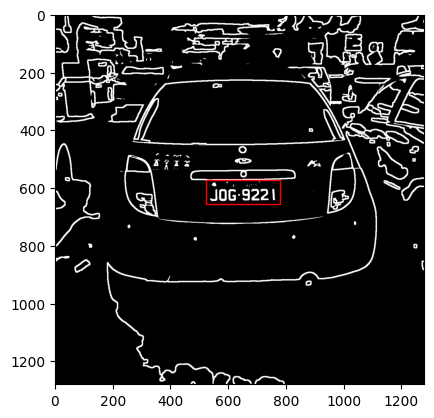

In [19]:
ds_img = ds.image_at(20)
img = ds_img.image
img = only_apply(img, start + segmentation)
show(img, ds_img.plate_rect, cmap='gray')

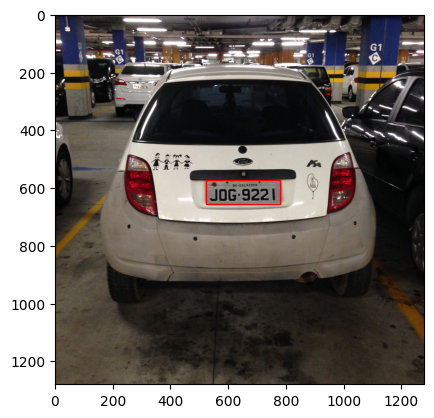

In [20]:
show(ds_img.image, ds_img.plate_rect)

In [21]:
# Como encontrar regiões candidatas
# 1. Calcular contornos;
# 2. Obtemos os retângulos que esses contornos fazem parte;
# 3. Buscamos regiões com múltiplos retângulos próximos;
# 4. Dependendo da quantidade de retângulo da vizinha, adicionamos essa região como candidata;
# =====================================================

# Obtendo contornos externos
img_h, img_w = img.shape
contours, _ = cv2.findContours(img,
                               cv2.RETR_LIST,
                               cv2.CHAIN_APPROX_SIMPLE)

# Obtendo os retângulos
rectangles = [cv2.boundingRect(c) for c in contours]
print(f'Encontrados {len(rectangles)} retângulos...')

# Filtrando retângulos "grandes"
max_ratio = 0.4
rectangles = [r
              for r in rectangles
              if (r[2] <= max_ratio * img_w)
              and (r[3] <= max_ratio * img_h)]
print(f'Restaram {len(rectangles)} retângulos após '
      'remoção de retângulos grandes...')

# Filtrando retângulos "pequenos"
min_ratio = 0.005
rectangles = [r
              for r in rectangles
              if (r[2] >= min_ratio * img_w)
              and (r[3] >= min_ratio * img_h)]
print(f'Restaram {len(rectangles)} retângulos após '
      'remoção de retângulos pequenos...')

# Removendo retângulos com proporção inviável para
#   caractere
max_ch_prop = 0.75
rectangles = [r
              for r in rectangles
              if (r[2] / r[3] <= max_ch_prop)]
print(f'Restaram {len(rectangles)} retângulos após '
      'remoção de retângulos com proporção inviável...')


def _indices_to_remove_overlap(all_rectangles: list[tuple],
                               threshold: float) -> list[int]:
    polygons = sorted([(i, shapely.box(xmin=x, xmax=x + w,
                                       ymin=y, ymax=y + h))
                       for i, (x, y, w, h) in enumerate(all_rectangles)],
                      key=lambda e: e[1].area)
    indices = []
    for i, (idx, p) in enumerate(polygons):
        for j, p_ in polygons[i+1:]:
            if p.intersects(p_):
                int_area = shapely.intersection(p_, p).area
                min_area = p.area

                assert int_area >= 0.0
                assert min_area <= p_.area, f'{min_area} > {p_.area}'

                if int_area >= threshold * min_area:
                    indices.append(idx)
                    break

    return indices


# Removendo retângulos que possuem overlap
overlap_th: float = 0.6
to_remove = sorted(_indices_to_remove_overlap(rectangles,
                                              overlap_th),
                   reverse=True)
for idx in to_remove:
    del rectangles[idx]

print(f'Restaram {len(rectangles)} após remoção '
      'de overlap...')


def _distance(rect_a, rect_b) -> float:
    # Obtendo dados dos retângulos
    xa, ya, wa, ha = rect_a
    xb, yb, wb, hb = rect_b

    # Calculamos o centro
    ca = np.array([xa + wa // 2,
                   ya + ha // 2])
    cb = np.array([xb + wb // 2,
                   yb + hb // 2])

    # Calculando a normal do vetor distância
    return _euclidean_distance(ca, cb)


def _euclidean_distance(arr_a: np.ndarray,
                        arr_b: np.ndarray) -> float:
    return np.sqrt(np.sum((arr_a - arr_b) ** 2))


def _has_neighbor(idx: int,
                  all_rectangles: list[tuple],
                  proximity_th: float) -> bool:
    # Obtendo retângulo
    rect = all_rectangles[idx]

    # Calculando distância dos demais retângulos
    others = all_rectangles[:idx] + all_rectangles[idx+1:]
    distances = list(map(lambda r: _distance(rect, r),
                         others))
    others = sorted(zip(distances, others),
                    key=lambda t: t[0])

    # Checando se possui vizinho
    nearest_dist = others[0][0]
    return nearest_dist <= proximity_th


# Removendo retângulos que não possuem vizinhos
diagonal_size = _euclidean_distance(np.array([0, 0]),
                                    np.array([img_w, img_h]))
neighbor_th = 0.05
rectangles = [r for i, r in enumerate(rectangles)
              if _has_neighbor(i,
                               rectangles,
                               diagonal_size * neighbor_th)]
print(f'Restaram {len(rectangles)} retângulos após '
      'remoção dos sem vizinhos próximos...')


# Buscando regiões com maior densidade de retângulos através
#   da dilatação dos retângulos.
blobs = np.zeros((img_h, img_w),
                 dtype=np.uint8)

# Colocamos os retângulos encontrados na cor branca
for r in rectangles:
    x, y, w, h = r
    blobs[y:y+h, x:x+w] = 1


# Dilatamos os retângulos para formar um retângulo maior
blobs = cv2.dilate(blobs,
                   cv2.getStructuringElement(cv2.MORPH_RECT,
                                             (20, 20)),
                   iterations=2)

# Obtemos os novos contornos
blobs_contours, _ = cv2.findContours(blobs,
                                     cv2.RETR_EXTERNAL,
                                     cv2.CHAIN_APPROX_SIMPLE)

# Calculamos os últimos candidatos
candidates = [cv2.boundingRect(c) for c in blobs_contours]
candidates = [c for c in candidates
              if c[2] / c[3] > 0.7]
print('Candidatos finais:', len(candidates))

Encontrados 288 retângulos...
Restaram 284 retângulos após remoção de retângulos grandes...
Restaram 163 retângulos após remoção de retângulos pequenos...
Restaram 32 retângulos após remoção de retângulos com proporção inviável...
Restaram 28 após remoção de overlap...
Restaram 18 retângulos após remoção dos sem vizinhos próximos...
Candidatos finais: 4


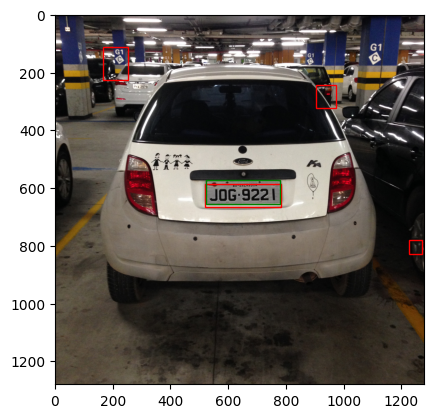

In [22]:
fig, ax = plt.subplots()
ax.imshow(ds_img.image)
for r in candidates:
    x, y, w, h = r
    ax.add_patch(patches.Rectangle((x, y), w, h,
                                   linewidth=1,
                                   edgecolor='r',
                                   facecolor='none'))

x, y, w, h = ds_img.plate_rect
ax.add_patch(patches.Rectangle((x, y), w, h,
                               linewidth=1,
                               edgecolor='g',
                               facecolor='none'))

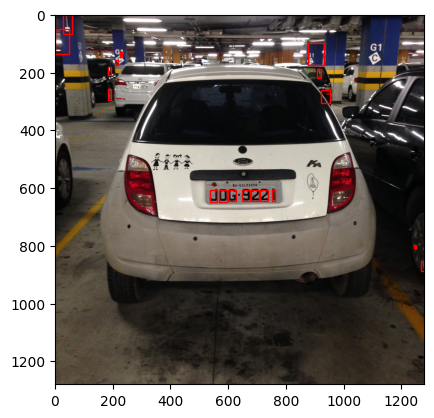

In [23]:
fig, ax = plt.subplots()
ax.imshow(ds_img.image)
for r in rectangles:
    x, y, w, h = r
    ax.add_patch(patches.Rectangle((x, y), w, h, 
                                linewidth=1, 
                                edgecolor='r', 
                                facecolor='none'))

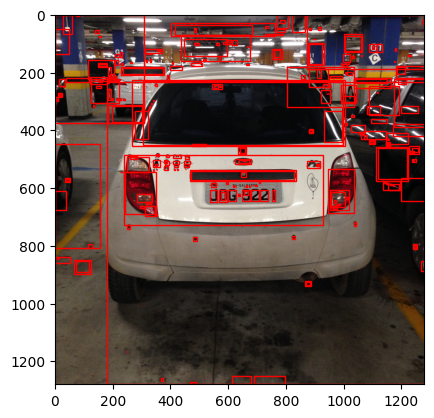

In [24]:
fig, ax = plt.subplots()
ax.imshow(ds_img.image)
for r in [cv2.boundingRect(c) for c in contours]:
    x, y, w, h = r
    ax.add_patch(patches.Rectangle((x, y), w, h, 
                                linewidth=1, 
                                edgecolor='r', 
                                facecolor='none'))

In [25]:
# Como selecionar a região de placa
# 1. Para todas regiões candidatas, aplicamos o classificador;
# 2. 

In [26]:
if False:
    for i in range(0, ds.total_images(), 5):
        ds_img = ds.image_at(i)
        img = only_apply(ds_img.image, start + segmentation)
        show(img, ds_img.plate_rect, cmap='gray')    
        plt.show()